We're going to analyze the performance of some competing implementations of e-divisive with means calculators.

Let's start by importing stuff:

In [79]:
import time
import numpy as np
import matplotlib.pyplot as plt
import ruptures as rpt
from signal_processing_algorithms.e_divisive import EDivisive
from signal_processing_algorithms.e_divisive.base import EDivisiveCalculator
from signal_processing_algorithms.e_divisive.calculators import cext_calculator, numpy_calculator
from signal_processing_algorithms.e_divisive.significance_test import QHatPermutationsSignificanceTester
from signal_processing_algorithms.e_divisive import default_implementation
from collections import OrderedDict

In [2]:
from numpy_calculator import NumpyCalculator
from numpy_windowed_calculator import NumpyWindowedCalculator
from optimized_calculator import OptimizedCalculator
from original_calculator import OriginalCalculator
from windowed_calculator import WindowedCalculator

We're going to be making our e-divisive algorithm in a standard way, only switching out the calculator being used:

In [3]:
def make_e_divisive(calculator):
    tester = QHatPermutationsSignificanceTester(
        calculator=calculator, pvalue=0.05, permutations=100
    )
    return EDivisive(seed=1234, calculator=calculator, significance_tester=tester)

So, we've got the following below:
* Default implemetation provided by this package
* Using the numpy calculator provided by this package
* Using the C extension provided by this package (this is the default implementation, for the record)
* Using a window based calculator
* Using a window based calculator, that leverages numpy
* Using an "optimized" calculator -- updating terms using deltas rather than recalculating them
* The original calculator, using straight python w/o numpy for sums and recalculating terms
* Using numpy for sums

In [67]:
implementations = {
    "default_implementation": default_implementation(),
    "normal": make_e_divisive(numpy_calculator),
    "c_extension": make_e_divisive(cext_calculator), # This is the default implementation, under the covers
    "windowed": make_e_divisive(WindowedCalculator),
    "numpy_windowed": make_e_divisive(NumpyWindowedCalculator),
    "optimized": make_e_divisive(OptimizedCalculator),
    "original": make_e_divisive(OriginalCalculator),
    "numpy": make_e_divisive(NumpyCalculator),
}

Our first test will be generating time series with lengths between 100 and 1000, inclusive, in steps of 10. Each time series will contain 4 mean shifts, and 1 standard deviation worth of noise.

In [132]:
def make_test(lengths, num_bkps, noise):
    test_series = []

    for length in lengths:
        signal, bkps = rpt.pw_constant(length, 1, num_bkps, noise_std=noise)
        feed_signal = [x[0] for x in signal]
        test_series.append((signal, feed_signal, bkps))
    results = {}
    for name, implementation in implementations.items():
        lengths = []
        times = []
        for series, feed_signal, bkps in test_series:
            alg = default_implementation()
            s = time.time()
            alg.fit_predict(feed_signal)
            e = time.time() - s
            times.append(e)
            lengths.append(len(feed_signal))
        results[name] = (lengths, times)
    for name, res in results.items():
        plt.plot(res[0], res[1], label=name)
    plt.legend()

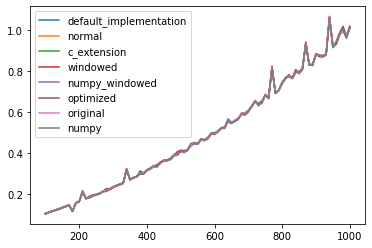

In [182]:
make_test(range(100, 1010, 10), 4, 1)

Looks pretty similar, lets try it over 1000 to 5000 inclusive, using steps of 100:

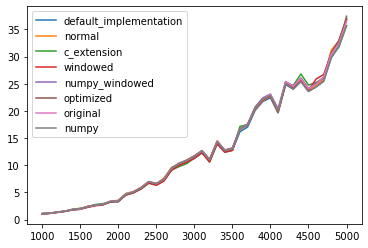

In [183]:
make_test(range(1000, 5100, 100), 4, 1)

At these scales, there doesn't seem to be a significant difference between the calculators. 